In [17]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep, load_regression
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import random
import json
import multiprocessing
from joblib import Parallel, delayed
import os

sns.set_theme()

In [2]:
json_dir = 'intervals/'

data = []

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data.append(series)

df = pd.DataFrame(data)
df['level'] = df['level'].round(2)


In [3]:
json_dir_qrf = 'qrf_intervals/'

data_qrf = []

for filename in os.listdir(json_dir_qrf):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir_qrf, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data_qrf.append(series)

df_qrf = pd.DataFrame(data_qrf)
df_qrf['level'] = df_qrf['level'].round(2)

In [4]:
df.head()

,data_name,n_neighbors,level,random_state,test_size,n,d,oob_score,test_score,coverage,width_mean,width_sd,width_min,width_q1,width_q2,width_q3,width_max
0,AirfoilSelfNoise,1000,0.8,1424,0.2,1503,5,0.929047,0.939969,0.787375,0.558624,0.003294,0.551086,0.556368,0.558412,0.560715,0.569262
1,AirfoilSelfNoise,1000,0.8,1679,0.2,1503,5,0.931532,0.921016,0.817276,0.591467,0.004108,0.583381,0.589737,0.590672,0.595351,0.598019
2,AirfoilSelfNoise,1000,0.8,1824,0.2,1503,5,0.935500,0.939585,0.857143,0.569110,0.003090,0.561692,0.568846,0.569253,0.570166,0.576286
3,AirfoilSelfNoise,1000,0.8,2286,0.2,1503,5,0.930411,0.924007,0.820598,0.608010,0.003708,0.602255,0.606187,0.606187,0.607820,0.615719
4,AirfoilSelfNoise,1000,0.8,3657,0.2,1503,5,0.932849,0.929926,0.794020,0.558336,0.001894,0.553570,0.557365,0.558369,0.560093,0.563470


In [5]:
df_qrf.head()

,data_name,n_neighbors,level,random_state,test_size,n,d,oob_score,test_score,coverage,width_mean,width_sd,width_min,width_q1,width_q2,width_q3,width_max
0,AirfoilSelfNoise,qrf,0.8,1424,0.2,1503,5,None,None,0.823920,0.778640,0.406924,0.090162,0.480818,0.730722,0.998064,2.720965
1,AirfoilSelfNoise,qrf,0.8,1679,0.2,1503,5,None,None,0.833887,0.789399,0.413840,0.002899,0.468265,0.732461,1.014284,2.808083
2,AirfoilSelfNoise,qrf,0.8,1824,0.2,1503,5,None,None,0.857143,0.724954,0.425916,0.085988,0.443275,0.627441,0.882781,2.720965
3,AirfoilSelfNoise,qrf,0.8,2286,0.2,1503,5,None,None,0.823920,0.752000,0.394019,0.026672,0.475455,0.697484,0.906118,2.359880
4,AirfoilSelfNoise,qrf,0.8,3657,0.2,1503,5,None,None,0.837209,0.766997,0.433269,0.050285,0.484877,0.655635,0.955940,2.958837


In [6]:
df_combined = pd.concat([df, df_qrf], axis=0)

In [7]:
pd.pivot_table(df_combined, values = ['width_mean'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.mean, margins = False).reset_index().to_csv('temp_width_mean.csv')

In [8]:
pd.pivot_table(df_combined, values = ['width_sd'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.std, margins = False).reset_index().to_csv('temp_width_std.csv')

In [9]:
pd.pivot_table(df_combined, values = ['coverage'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.mean, margins = False).reset_index().to_csv('temp_coverage_mean.csv')

In [10]:
df_combined.groupby(['level', 'n_neighbors'])[['width_mean', 'width_sd']].mean()

width_mean      width_sd
level n_neighbors                          
0.80  5              0.481580  3.851565e-01
      10             0.554590  3.777625e-01
      20             0.600376  3.418583e-01
      50             0.632498  2.402119e-01
      100            0.635251  1.551980e-01
      200            0.606603  9.569288e-02
      500            0.686947  4.665932e-02
      1000           0.730509  2.677726e-02
      2000           0.688013  1.569770e-02
      5000           0.770621  4.870421e-03
      10000          0.810182  1.298683e-03
      all            0.645817  1.291114e-16
      auto           0.603494  3.465965e-01
      qrf            0.656320  4.970368e-01
0.90  5              0.557709  4.474596e-01
      10             0.718332  4.776586e-01
      20             0.789651  4.311392e-01
      50             0.891612  3.054074e-01
      100            0.923168  2.016489e-01
      200            0.921089  1.251681e-01
      500            1.056027  6.612156e-02
      1000           1.140529  3.881099e-02
      2000           1.113525  2.336466e-02
      5000           1.255738  6.135193e-03
      10000          1.225455  1.999810e-03
      all            0.990608  1.996584e-16
      auto           0.808362  4.563285e-01
      qrf            0.860465  5.885284e-01
0.95  5              0.595774  4.802387e-01
      10             0.800188  5.415029e-01
      20             0.977275  5.297479e-01
      50             1.117637  3.668574e-01
      100            1.203521  2.342691e-01
      200            1.243809  1.413447e-01
      500            1.426009  7.774465e-02
      1000           1.573290  4.375302e-02
      2000           1.570829  2.320730e-02
      5000           1.777384  6.410371e-03
      10000          1.686679  2.929345e-03
      all            1.347243  2.509032e-16
      auto           0.990524  5.508048e-01
      qrf            1.039375  6.510134e-01
0.99  5              0.626225  5.070600e-01
      10             0.865664  5.967273e-01
      20             1.127439  6.393273e-01
      50             1.540682  5.189507e-01
      100            1.845863  3.387737e-01
      200            1.898453  1.832869e-01
      500            2.109884  9.774773e-02
      1000           2.388631  4.898968e-02
      2000           2.450849  2.834716e-02
      5000           3.009555  1.269399e-02
      10000          2.626777  5.461473e-03
      all            2.199863  4.097999e-16
      auto           1.223294  6.673522e-01
      qrf            1.337100  7.564408e-01

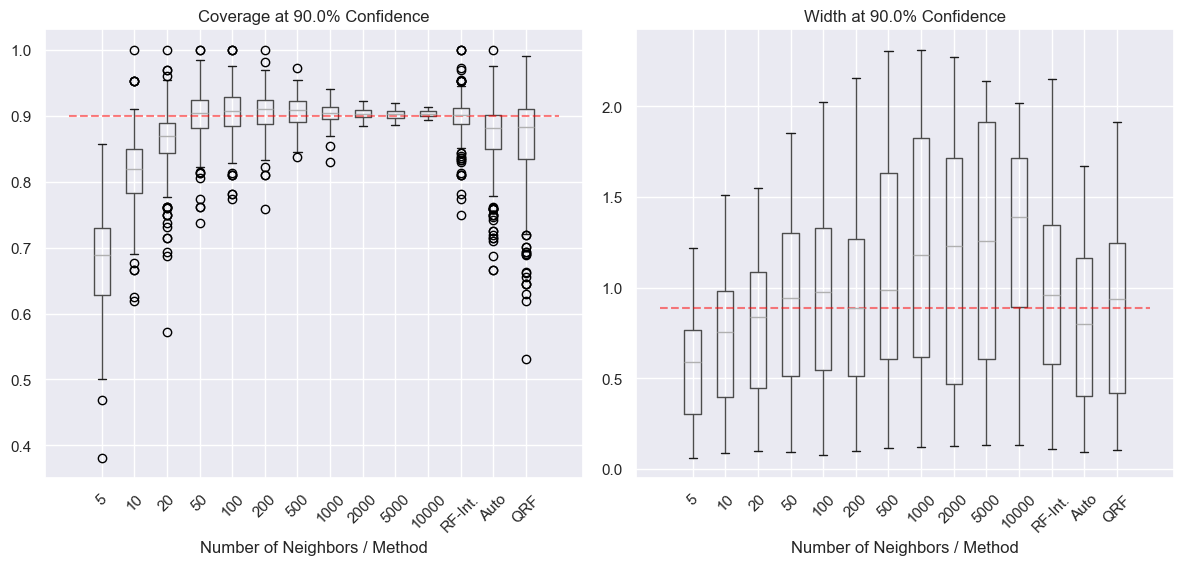

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
level = 0.90
df_level = df_combined[df_combined['level'] == level]

xtick_labels = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'RF-Int.', 'Auto', 'QRF']

df_level.boxplot(column='coverage', by=['n_neighbors'], ax = ax[0])
ax[0].hlines(level, 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[0].set_title(f'Coverage at {level * 100}% Confidence')
ax[0].set_xticklabels(xtick_labels, rotation = 45)
ax[0].set_xlabel('Number of Neighbors / Method')

df_level.boxplot(column='width_mean', by=['n_neighbors'], ax = ax[1])
ax[1].hlines(df_level.width_mean.mean(), 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[1].set_title(f'Width at {level * 100}% Confidence')
ax[1].set_xticklabels(xtick_labels, rotation = 45)
ax[1].set_xlabel('Number of Neighbors / Method')

fig.suptitle('')
plt.tight_layout()
plt.savefig('coverage_width.pdf')



<Axes: xlabel='coverage', ylabel='width_mean'>

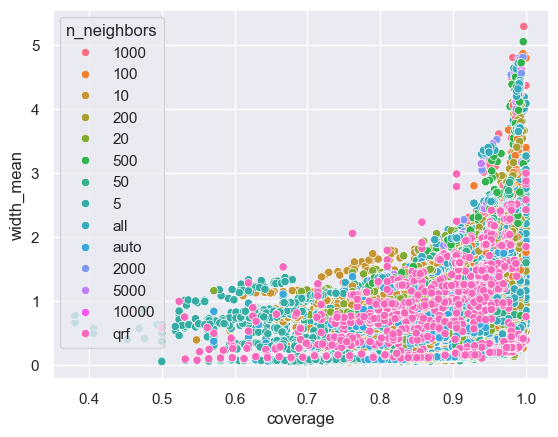

In [19]:
sns.scatterplot(data = df_combined, x = 'coverage', y = 'width_mean', hue = 'n_neighbors')

<Axes: title={'center': 'width_mean'}, xlabel='[n_neighbors]'>

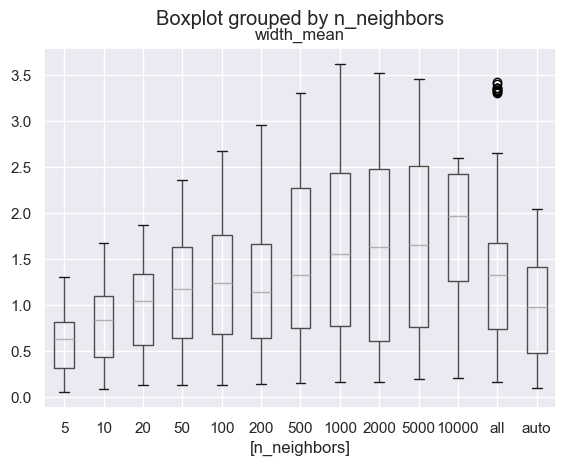

In [13]:
df[df['level'] == 0.95].boxplot(column='width_mean', by=['n_neighbors'])

In [14]:
df[df['level'] == 0.95].groupby('data_name')['width_mean'].mean()

data_name
AirQuality                     2.341191
AirfoilSelfNoise               0.907983
AutoMPG                        1.170119
Automobile                     1.149317
BeijingPM25                    1.440167
CommunityCrime                 2.068216
ComputerHardware               0.866041
ConcreteCompressiveStrength    1.062530
ConcreteSlumpTest              1.514581
CyclePowerPlant                0.690449
EnergyEfficiency               0.624978
FacebookMetrics                0.235972
FiveCitiesPM25                 2.035684
Hydrodynamics                  0.216320
IstanbulStock                  1.230478
Naval Propulsion Plants        0.187451
OpticalNetwork                 0.565979
Parkinsons                     1.408892
Protein                        2.200072
SML2010                        0.164706
Name: width_mean, dtype: float64

In [15]:
df.groupby('data_name')['n'].mean()

data_name
AirQuality                      9357.0
AirfoilSelfNoise                1503.0
AutoMPG                          392.0
Automobile                       159.0
BeijingPM25                    41757.0
CommunityCrime                  1994.0
ComputerHardware                 209.0
ConcreteCompressiveStrength     1030.0
ConcreteSlumpTest                103.0
CyclePowerPlant                 9568.0
EnergyEfficiency                 768.0
FacebookMetrics                  495.0
FiveCitiesPM25                 21436.0
Hydrodynamics                    308.0
IstanbulStock                    536.0
Naval Propulsion Plants        11934.0
OpticalNetwork                   630.0
Parkinsons                      5875.0
Protein                        45730.0
SML2010                         4137.0
Name: n, dtype: float64

<Axes: xlabel='data_name', ylabel='width_q1'>

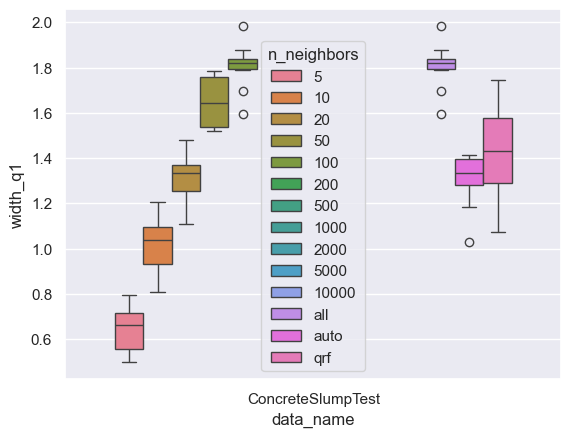

In [16]:
subset_df = df_combined[(df_combined['level'] == 0.95) & (df_combined['data_name'] == 'ConcreteSlumpTest')]
# subset_df = df[(df['level'] == 0.95)]

hue_order = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'all', 'auto', 'qrf']


sns.boxplot(subset_df, x = 'data_name', y = 'width_q1', hue='n_neighbors',
            hue_order = hue_order)